### Victor M. Zavala 2016 
### University of Wisconsin-Madison 

In [249]:
# Loading packages:

using JuMP 
using Distributions 
using Ipopt
using PyPlot 

In [250]:
N = [10, 100, 1000]
storeobj = [];

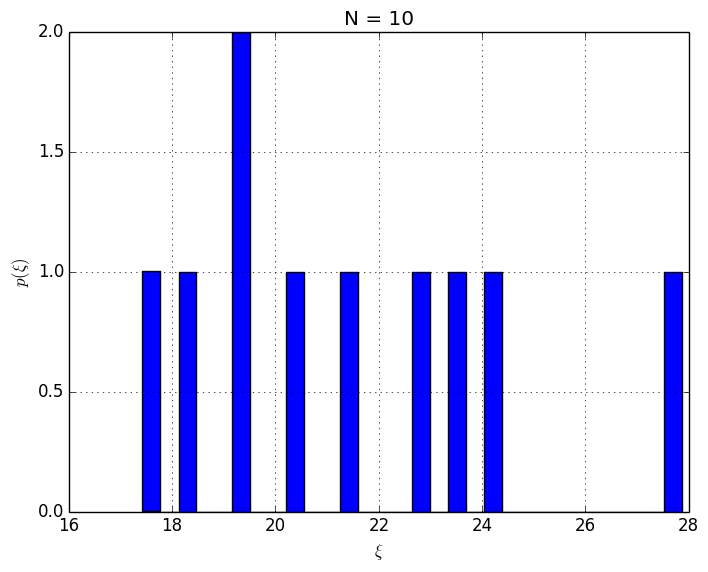

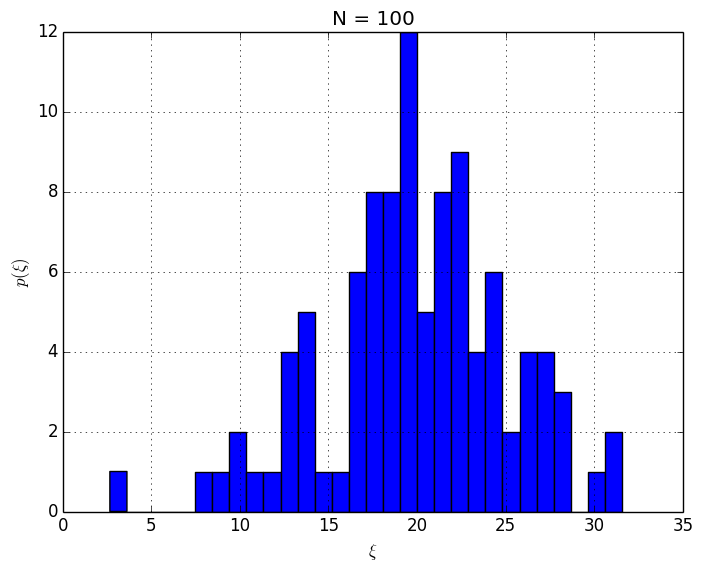

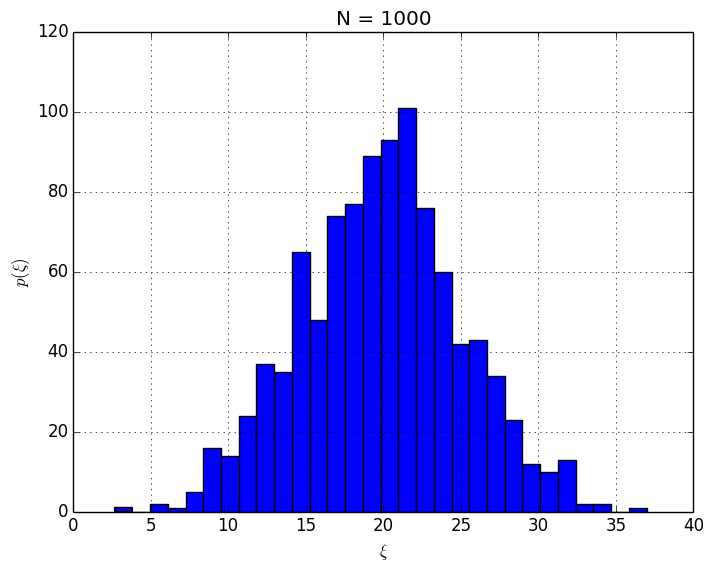

In [251]:
for i in N  
 
    # Generating random data: 
    srand(0)
    μ = 20; σ = 5
    d = Normal(μ,σ)
    R = rand(d,i)
    
    # Plotting:
    figure()
    plt[:hist](R, bins = 30)
    grid("on")
    xlabel(L"\xi")
    ylabel(L"p(\xi)")
    title("N = $i")
    #savefig("ex1data.pdf")
    
    M = 5
    B = zeros(i,M)
    srand(0)

    for j=1:M
        B[:,j] = rand(d,i)
    end
    
    # Problem data: 

    prcost = zeros(3)
    prcost[1] = 150
    prcost[2] = 230
    prcost[3] = 260

    pcost = zeros(3)
    pcost[1] = 238
    pcost[2] = 210
    pcost[3] = 0

    scost = zeros(3)
    scost[1] = 170
    scost[2] = 150
    scost[3] = 36

    demand = zeros(3)
    demand[1] = 200
    demand[2] = 240
    demand[3] = 0;
    
    # Model parameters: 

    NS = i;                    # number of scenarios  (CHECK THIS PART: is it always going to be 1000 or N?)
    S = collect(1:NS)          # scenario set
    P = collect(1:3)           # set of crops (1=wheat,2=corn,3=beets)

    # assign random data

    yield = zeros(length(S),3)
    yield[S,1] = 2.5
    yield[S,2] = 3.0

    yielddata = R
    yieldbatch = B

    # get candidate solution

    yield[S,3] = yielddata;
    
    
    
    # Model:

    m = Model(solver=IpoptSolver(print_level=0))

    @defVar(m, x[S,P] >= 0)    # acres devoted to crops
    @defVar(m, y[S,P] >= 0)    # crops purchase
    @defVar(m, w[S,P] >= 0)    # crops sold;
    @defExpr(m, Cost[s in S], sum{prcost[j]*x[s,j] + pcost[j]*y[s,j] - scost[j]*w[s,j], j in P})
    @defVar(m, cost[s in S])


    @addConstraint(m, varcost[s in S], cost[s] == Cost[s]) 
    @addConstraint(m, cap[s in S], sum{x[s,j], j in P} <= 500)
    @addConstraint(m, bal[s in S,j in P], yield[s,j]*x[s,j]+y[s,j]-w[s,j] >= demand[j]) 
    @addConstraint(m, sellb[s in S], w[s,3] <= 6000)
    @addConstraint(m, buyb[s in S], y[s,3] <= 0)
    @addConstraint(m, nonant[s in S,j in P], x[1,j] == x[s,j])

    @setObjective(m, Min, (1/NS)*sum{cost[s], s in S})

    solve(m)

    xs = getValue(x)
    
    
    # Get upper bound:

    function solveUpperBound(xs,yield,prcost,pcost,scost,demand)

        m = Model(solver=IpoptSolver(print_level=0))

        @defVar(m, y[S,P] >= 0)    # crops purchase
        @defVar(m, w[S,P] >= 0)    # crops sold;
        @defExpr(m, Cost[s in S], sum{prcost[j]*xs[s,j] + pcost[j]*y[s,j] - scost[j]*w[s,j], j in P})
        @defVar(m, cost[s in S])


        @addConstraint(m, varcost[s in S], cost[s] == Cost[s]) 
        @addConstraint(m, bal[s in S,j in P], yield[s,j]*xs[s,j]+y[s,j]-w[s,j] >= demand[j]) 
        @addConstraint(m, sellb[s in S], w[s,3] <= 6000)
        @addConstraint(m, buyb[s in S], y[s,3] <= 0)

        @setObjective(m, Min, (1/NS)*sum{cost[s], s in S})

        solve(m)

        return getObjectiveValue(m)
    end

    upobj = zeros(M)

    for j=1:M
        yield[S,3] = yieldbatch[S,j]
        upobj[j] = solveUpperBound(xs,yield,prcost,pcost,scost,demand)
    end
    
    
    # Get lower bound: 

    function solveLowerBound(yield,prcost,pcost,scost,demand)
    
        m = Model(solver=IpoptSolver(print_level=0))

        @defVar(m, x[S,P] >= 0)    # acres devoted to crops
        @defVar(m, y[S,P] >= 0)    # crops purchase
        @defVar(m, w[S,P] >= 0)    # crops sold;
        @defExpr(m, Cost[s in S], sum{prcost[j]*x[s,j] + pcost[j]*y[s,j] - scost[j]*w[s,j], j in P})
        @defVar(m, cost[s in S])

        @addConstraint(m, varcost[s in S], cost[s] == Cost[s]) 
        @addConstraint(m, cap[s in S], sum{x[s,j], j in P} <= 500)
        @addConstraint(m, bal[s in S,j in P], yield[s,j]*x[s,j]+y[s,j]-w[s,j] >= demand[j]) 
        @addConstraint(m, sellb[s in S], w[s,3] <= 6000)
        @addConstraint(m, buyb[s in S], y[s,3] <= 0)
        @addConstraint(m, nonant[s in S,j in P], x[1,j] == x[s,j])

        @setObjective(m, Min, (1/NS)*sum{cost[s], s in S})

        solve(m)
    
        return getObjectiveValue(m)
    end

    loobj = zeros(M)

    for j=1:M
        yield[S,3] = yieldbatch[S,j]
        loobj[j] = solveLowerBound(yield,prcost,pcost,scost,demand)
    end
    
    if i==10
        storeobj = [upobj';loobj']  # storing the upper and lower bounds 
    else 
        storeobj = [storeobj; upobj'; loobj']
    end
     
     
end

In [252]:
# Plotting part: (farmerinference.m)

# get critical values

srand(0)
α = 0.05
pd = rand(Normal(),1000)  # check this part! (it is running similar to matlab at least, I checked)
z = quantile(pd, 1 - α/2);

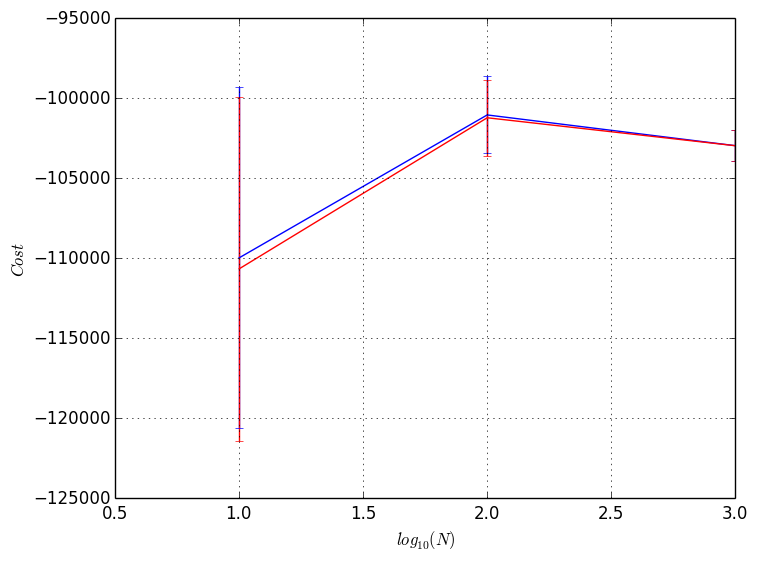

PyObject <matplotlib.text.Text object at 0x32e9f6f10>

In [255]:
Um = zeros(3); Uv = zeros(3)
Lm = zeros(3); Lv = zeros(3)

# N=10 samples
ups = storeobj[1,:]
los = storeobj[2,:]

Um[1] = mean(ups)
Uv[1] = std(ups)*z/sqrt(M)

Lm[1] = mean(los)
Lv[1] = std(los)*z/sqrt(M)


# N=100 samples
ups = storeobj[3,:]
los = storeobj[4,:]

Um[2] = mean(ups)
Uv[2] = std(ups)*z/sqrt(M)

Lm[2] = mean(los)
Lv[2] = std(los)*z/sqrt(M)


# N=1000 samples
ups = storeobj[5,:]
los = storeobj[6,:]

Um[3] = mean(ups)
Uv[3] = std(ups)*z/sqrt(M)

Lm[3] = mean(los)
Lv[3] = std(los)*z/sqrt(M)

gap = Um - Lm;
lgap = (Um + Uv) - (Lm - Lv);
cfU = Um + Uv;
cfL = Lm - Lv;

# Plotting:

errorbar([1,2,3],Um, yerr=Uv, fmt="b-");
hold("on")
errorbar([1,2,3],Lm, yerr=Lv, fmt="r-");
grid("on")
xlabel(L"log_{10}(N)")
ylabel(L"Cost")
#axis([0.5,3.5,-125000,-98000])
#savefig("inferencefarmer.pdf") 
